# Models

In [1]:
import time
import datetime
import numpy as np
import pandas as pd
from statsmodels.discrete.discrete_model import Logit
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.base import BaseEstimator, ClassifierMixin
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from pprint import pprint
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# %run /content/drive/MyDrive/DentistDataAnalysis/Experiments/Mappings.ipynb
%run Mappings.ipynb

In [3]:
# DIR = '/content/drive/MyDrive/DentistDataAnalysis/Experiments/'
DIR = ''

In [4]:
data = pd.read_csv(DIR+'dataset/final_data.csv')

In [5]:
X_cols = ['Que1', 'Que2', 'Que3', 'Que4', 'Que5', 'Que6', 'Que10_a', 'Que10_b', 'Que10_c', 'Que10_d', 'Que10_e', 'Que10_f', 'Que14', 'Que15', 'Que17', 'Que18_age', 'Que19', 'Que20', 'Que21', 'Que22', 'Que_smoking']
y_col = ['Que16']

## Metrics

In [6]:
def get_metrics(y_true, prediction):
    recall = round(recall_score(y_true, prediction), 4)
    accuracy = round(accuracy_score(y_true, prediction), 4)
    precision = round(precision_score(y_true, prediction), 4)
    roc_auc = round(roc_auc_score(y_true, prediction), 4) 
    f1 = round(f1_score(y_true, prediction), 4)
    conf_matrix = confusion_matrix(y_true, prediction).flatten()
    
    '''
    print('Test recall:\t', str(recall))
    print('Test accuracy:\t', str(accuracy))
    print('Test precision:\t', str(precision))
    print('Test ROC AUC:\t', str(roc_auc))
    print('Test F1 score:\t', str(f1))
    print('Test confusion matrix:\t'+ str(conf_matrix))
    '''
    return recall, accuracy, precision, roc_auc, f1, conf_matrix

## Logit

In [7]:
def perform_logit(X_train, y_train, X_test, y_test, X_cols, y_col):
    X_train_df = pd.DataFrame(data=X_train, columns=X_cols)
    y_train_df = pd.DataFrame(data=y_train, columns=y_col)
    kf = StratifiedKFold(n_splits=5)
    best_model = None
    best_score = None
    start_time = time.time()
    for train_index, test_index in kf.split(X_train_df, y_train_df):
        X_train_lg, X_test_lg = X_train_df.iloc[train_index], X_train_df.iloc[test_index]
        y_train_lg, y_test_lg = y_train_df.iloc[train_index], y_train_df.iloc[test_index]

        X_train_lg = sm.add_constant(X_train_lg)
        logit = Logit(y_train_lg, X_train_lg)
        results = logit.fit()
        X_test_lg = sm.add_constant(X_test_lg)
        yhat = results.predict(X_test_lg)
        prediction = list(map(round, yhat))
        recall = round(recall_score(y_test_lg, prediction), 4)
        
        if best_score==None or best_score<recall:
            best_score = recall
            best_model = results
    end_time = time.time()
    conv_time = datetime.timedelta(seconds=end_time-start_time)
    
    params = results.params
    X_test = sm.add_constant(X_test)
    yhat = best_model.predict(X_test)
    prediction = list(map(round, yhat))
    return best_score, get_metrics(y_test, prediction), conv_time, params

## Random forest

In [8]:
def perform_random_forest(X_train, y_train, X_test, y_test):
    #hyperparameters config
    n_estimators = [int(x) for x in np.linspace(start = 5, stop = 150, num = 15)]
    criterion = ['gini', 'entropy']
    max_features = ['sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True]
    random_grid = {'n_estimators': n_estimators,
                   'criterion': criterion,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    #grid search config
    rf_scoring='recall'
    rf_cv = 5
    rf_verbose=1
    rf_n_jobs=-1
    rf_return_train_score=True
    rf = RandomForestClassifier()
    rf_grid = GridSearchCV(estimator=rf, 
                            param_grid=random_grid,
                            scoring=rf_scoring, cv=rf_cv, 
                            verbose=rf_verbose, n_jobs=rf_n_jobs, 
                            return_train_score=rf_return_train_score)
    start_time = time.time()
    rf_grid.fit(X_train, y_train)
    end_time = time.time()
    conv_time = datetime.timedelta(seconds=end_time-start_time)
    
    val_score = round(rf_grid.best_score_, 4)
    params = rf_grid.best_params_
 
    rf_grid.best_estimator_.fit(X_train, y_train)
    prediction = rf_grid.best_estimator_.predict(X_test)
    metrics = get_metrics(y_test, prediction)
    
    start_time = time.time()
    importances = rf_grid.best_estimator_.feature_importances_
    std = np.std([rf_grid.best_estimator_.feature_importances_ for tree in rf_grid.best_estimator_.estimators_], axis=0)
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: " 
          f"{elapsed_time:.3f} seconds")
    forest_importances = pd.Series(importances, index=X_cols).sort_values(ascending=False)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    return val_score, metrics, conv_time, params

## Decision trees

In [9]:
def perform_decision_tree(X_train, y_train, X_test, y_test):
    #hyperparameters config
    criterion = ['gini', 'entropy']
    splitter = ['best', 'random']
    max_features = ['sqrt']
    max_depth = [int(x) for x in np.linspace(10, 50, num = 6)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    search_grid = {'criterion': criterion,
                   'splitter': splitter,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}
    #grid search config
    dtc_scoring='recall'
    dtc_cv = 5
    dtc_verbose=1
    dtc_n_jobs=-1
    dtc_return_train_score=True
    dtc = DecisionTreeClassifier()
    dtc_grid = GridSearchCV(estimator=dtc, 
                            param_grid=search_grid,
                            scoring=dtc_scoring, cv=dtc_cv, 
                            verbose=dtc_verbose, n_jobs=dtc_n_jobs, 
                            return_train_score=dtc_return_train_score)
    start_time = time.time()
    dtc_grid.fit(X_train, y_train)
    end_time = time.time()
    conv_time = datetime.timedelta(seconds=end_time-start_time)
    
    val_score = round(dtc_grid.best_score_, 4)
    params = dtc_grid.best_params_
    
    dtc_grid.best_estimator_.fit(X_train, y_train)
    prediction = dtc_grid.best_estimator_.predict(X_test)
    return val_score, get_metrics(y_test, prediction), conv_time, params

# Data preparation 

In [10]:
print(data.shape[0])
data_dropped = data.dropna()
print(data_dropped.shape[0])
data_train, data_test = train_test_split(data_dropped, test_size=400, random_state=42)
print(data_train.shape[0])
print(data_test.shape[0])
data_test_mapped = perform_mapping(data_test, questions_map_EN)
X_test = data_test.drop(columns=['Que16']).to_numpy()
y_test = data_test['Que16'].to_numpy()
print(np.unique(y_test, return_counts=True))
index_to_remove = data_test.index.to_numpy()
data_remain = data.drop(index_to_remove).reset_index(drop=True)
#strategy 1
data_dropped = data_remain.dropna().reset_index(drop=True)
data_dropped = perform_mapping(data_dropped, questions_map_EN)
#strategy 2
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
data_median = pd.DataFrame(imputer.fit_transform(data_remain))
data_median.columns = data_remain.columns
data_median.index = data_remain.index
data_median = perform_mapping(data_median, questions_map_EN)
#strategy 3
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
data_mean = pd.DataFrame(imputer.fit_transform(data_remain))
data_mean.columns = data_remain.columns
data_mean.index = data_remain.index
# mean values are not integer numbers so rounding to int was necessary
data_mean = data_mean.round()
data_mean = perform_mapping(data_mean, questions_map_EN)
#strategy 4
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_most_frequent = pd.DataFrame(imputer.fit_transform(data_remain))
data_most_frequent.columns = data_remain.columns
data_most_frequent.index = data_remain.index
data_most_frequent = perform_mapping(data_most_frequent, questions_map_EN)

4310
936
536
400
(array([0., 1.]), array([138, 262]))


In [11]:
def get_strategy_data(strategy=None):
    if strategy=='strategy1':
        X_train = data_dropped.drop(columns=['Que16']).to_numpy()
        y_train = data_dropped['Que16'].to_numpy()
    elif strategy=='strategy2':
        X_train = data_median.drop(columns=['Que16']).to_numpy()
        y_train = data_median['Que16'].to_numpy()
    elif strategy=='strategy3':
        X_train = data_mean.drop(columns=['Que16']).to_numpy()
        y_train = data_mean['Que16'].to_numpy()
    elif strategy=='strategy4':
        X_train = data_most_frequent.drop(columns=['Que16']).to_numpy()
        y_train = data_most_frequent['Que16'].to_numpy()
    else:
        X_train = None
        y_train = None
    return X_train, y_train

def get_balanced_data(X_train, y_train, balance=None):
    if balance=='no_balance':
        X_balanced = X_train
        y_balanced = y_train
    elif balance=='under':
        rus = RandomUnderSampler(random_state=0)
        X_balanced, y_balanced = rus.fit_resample(X_train, y_train)
    elif balance=='over':
        ros = RandomOverSampler(random_state=0)
        X_balanced, y_balanced = ros.fit_resample(X_train, y_train)
    elif balance=='smoteenn':
        smote_enn = SMOTEENN(random_state=0)
        X_balanced, y_balanced = smote_enn.fit_resample(X_train, y_train)
    else:
        X_balanced = None
        y_balanced = None
    return X_balanced, y_balanced

# Run models

Optimization terminated successfully.
         Current function value: 0.546577
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.546673
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.553735
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.553325
         Iterations 7
         Current function value: 0.550990
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.552845
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.580466
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.572934
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.588170
         Iterations 6
         Current function value: 0.547914
         Iterations: 35
Optimization terminated successfully.
         Curre

/home/miroslav/anaconda3/envs/master-env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/miroslav/anaconda3/envs/master-env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.557987
         Iterations 7
         Current function value: 0.214629
         Iterations: 35
Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Fitting 5 folds for each of 2970 candidates, totalling 14850 fits
0.8478
Elapsed time to compute the importances: 0.004 seconds
Fitting 5 folds for each of 2970 candidates, totalling 14850 fits
0.7115
Elapsed time to compute the importances: 0.426 seconds
Fitting 5 folds for each of 2970 candidates, totalling 14850 fits
0.7104
Elapsed time to compute the importances: 0.938 seconds
Fitting 5 folds for each of 2970 candidates, totalling 14850 fits
0.8905
Elapsed time to compute the importances: 0.064 seconds
Optimization terminated successfully.
         Current function 

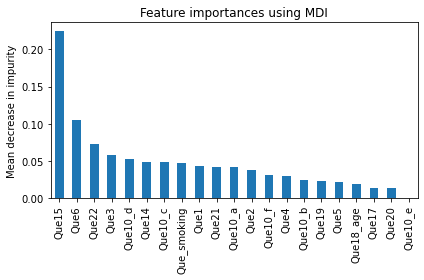

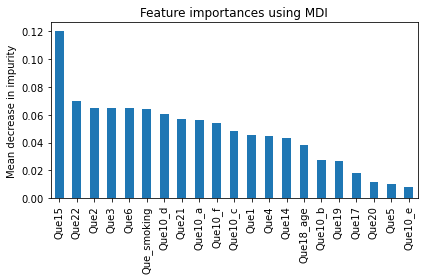

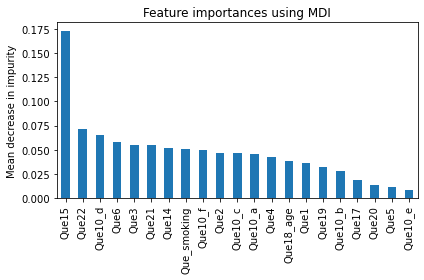

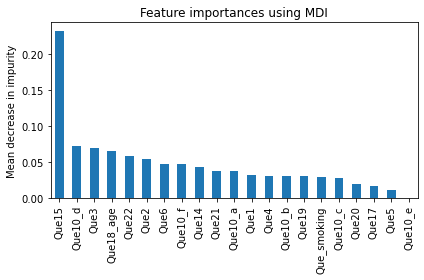

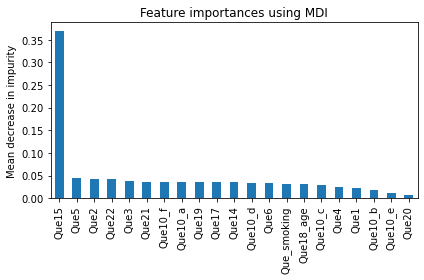

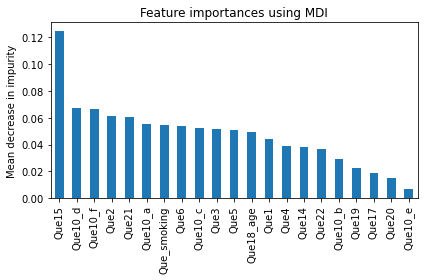

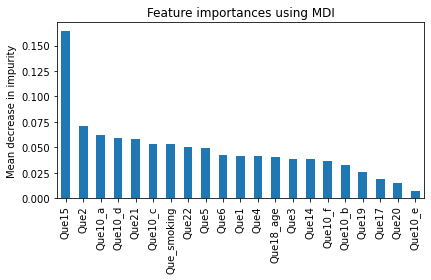

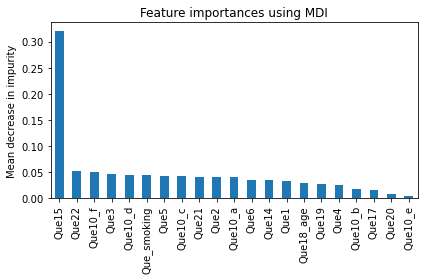

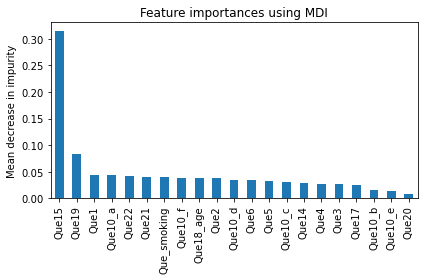

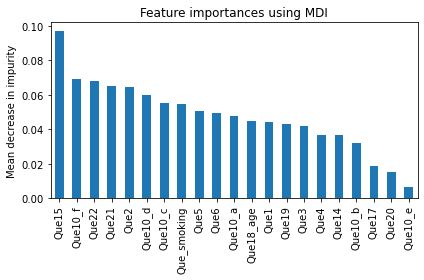

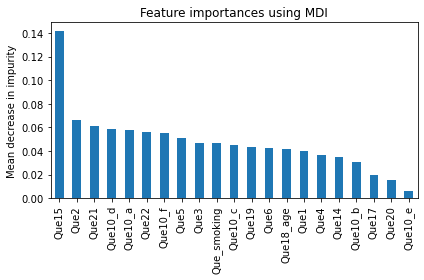

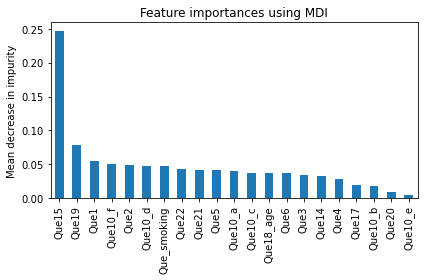

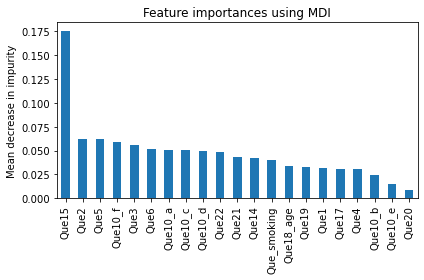

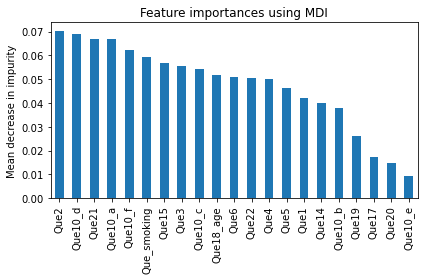

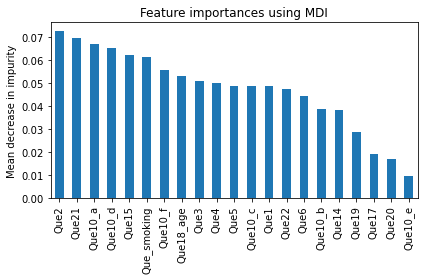

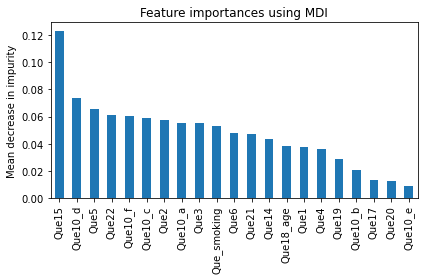

In [12]:
result_cols = ['strategy', 'model', 'balance', 'val_score', 'recall', 'accuracy', 'precision', 'roc_auc', 'f1-score', 'conf matrix', 'time', 'params']
key = 0
dict_metric = {}
strategies = ['strategy1', 'strategy2', 'strategy3', 'strategy4']
models = ['log_reg', 'dec_tree', 'rand_for']
balances = ['no_balance', 'under', 'over', 'smoteenn']
for strategy in strategies:
    for model in models:
        for balance in balances:
            dict_metric[key] = []
            dict_metric[key].extend([strategy, model, balance])
            X_train, y_train = get_strategy_data(strategy)
            X_train, y_train = get_balanced_data(X_train, y_train, balance)
            
            try:
                if model=='log_reg':
                    metrics = perform_logit(X_train, y_train, X_test, y_test, X_cols, y_col)
                    dict_metric[key].extend([metrics[0], metrics[1][0], metrics[1][1], metrics[1][2], metrics[1][3], metrics[1][4], metrics[1][5], metrics[2], metrics[3]])
                elif model=='dec_tree':
                    metrics = perform_decision_tree(X_train, y_train, X_test, y_test)
                    dict_metric[key].extend([metrics[0], metrics[1][0], metrics[1][1], metrics[1][2], metrics[1][3], metrics[1][4], metrics[1][5], metrics[2], metrics[3]])
                elif model=='rand_for':
                    metrics = perform_random_forest(X_train, y_train, X_test, y_test)
                    dict_metric[key].extend([metrics[0], metrics[1][0], metrics[1][1], metrics[1][2], metrics[1][3], metrics[1][4], metrics[1][5], metrics[2], metrics[3]])
                else:
                    print('Not existing model!')
                key+=1
            except:
                dict_metric[key].extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
                key+=1
                continue
result_df = pd.DataFrame.from_dict(dict_metric, orient='index', columns=result_cols)
result_df.to_csv(DIR+'dataset/results_'+str(time.time())+'.csv', index=False)